# Notebook based on the famous 1998 paper by Emanuel Derman:

# When You Cannot Hedge Continuously: The Corrections to Black-Scholes

The insight behind the Black-Scholes formula for options valuation is the recognition that, if you know the future volatility of a stock, you can replicate an option payoff exactly by a continuous rebalancing of a portfolio consisting of the underlying stock and a risk-free bond. If no arbitrage is possible, then the value of the option should be the cost of the replication strategy.
It is widely recognized that the Black-Scholes model is imperfect in many respects. It makes the idealized assumption that future stock evolution is lognormal with a known volatility, it ignores transaction costs and market impact, and it assumes that trading can be carried out continuously. Nevertheless the model is rational, and therefore amenable to rational modification of its assumptions and results; the Black-Scholes theory can be used to investigate its own shortcomings. This is an active area of research for the Quantitative Strategies Group at Goldman Sachs.
In this note we examine the effect of dropping only one of the key Black-Scholes assumptions, that of the possibility of continuous hedging. We examine the error that arises when you replicate a single option throughout its lifetime according to the Black-Scholes replication strategy, with the constraint that only a discrete number of rebalancing trades at regular intervals are allowed. To study the replication error, we carry out Monte Carlo simulations of the Black-Scholes hedging strategy for a single European-style option and analyze the resulting uncertainty (that is, the error) in the replication value. We will show that that these errors follow a simple rule-of-thumb that is related to statistical uncertainty that arises in estimating volatility from a discrete number of observations: the typical error in the replication value is proportional to the vega of the option (its volatility sensitivity, sometimes also called kappa) multiplied by the uncertainty in its observed volatility.

## Simulating The Hedging Scenario and Calculating the Replication Error

Suppose at time t = 0 the option hedger sells a European put with strike K and expiration t = T, and receives the Black-Scholes value as the options premium. We assume that the world operates within the Black-Scholes framework: the underlying stock price evolves lognormally with a fixed known volatility $\sigma$ that stays constant throughout time. For simplicity, we assume the stock pays no dividends.
The hedger now follows a Black-Scholes hedging strategy, rehedging at discrete, evenly spaced time intervals as the underlying stock changes. At expiration, the hedger delivers the option payoff to the option holder, and unwinds the hedge. We are interested in understanding the final profit or loss of this strategy:

Value of Final P&L = Black-Scholes hedge at T - Final option payoff

### Time to start coding

In [1]:
from __future__ import division

Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

In [3]:
%matplotlib inline

We'll start with the simulation of paths, and that starts with random samples from a standard normal distribution

In [4]:
nmdt=pd.Series(np.random.standard_normal(10000))

They look normal to me:

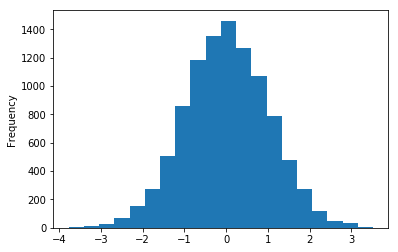

In [5]:
nmdt.plot(kind='hist', bins=20)

Auxiliary functions

In [6]:
def ca(x,size):
    y=np.empty(size)
    y.fill(x)
    return y

In [7]:
def ppzero(s):
    return pd.Series(pd.Series.append(pd.Series([0]),s).values)

Monte Carlo path generator

In [8]:
def mcpath(nsteps, S0, drift, vol, t):
    # generate random numbers
    nmdr=pd.Series(np.random.standard_normal(nsteps))
    # find each step
    dt=t*1/nsteps
    ts=pd.Series(ca(dt,nsteps))
    ts0=ppzero(ts)
    s1=(drift-(vol**2)/2)*dt
    s2=vol*np.sqrt(dt)
    steps=s1*pd.Series(ca(1,nsteps))+s2*nmdr
    steps0=ppzero(steps)
    # add steps
    cmsteps=steps0.cumsum()
    cts=ts0.cumsum()
    # convert steps to path
    Sj=S0*np.exp(cmsteps.values)
    # return timeseries [t,St]
    return pd.Series(Sj,index=cts.values)

In [9]:
testpath=mcpath(10,100,0.10,0.20,1)

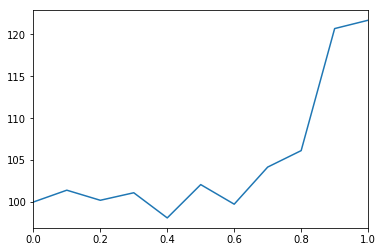

In [10]:
testpath.plot()

Monte Carlo path generator with downsampling (returns both paths, original and downsampled)

In [11]:
def mcpathsmpl(nsteps, smpl, S0, drift, vol, t):
    # generate random numbers
    nmdr=pd.Series(np.random.standard_normal(nsteps))
    # find each step
    dt=t*1/nsteps
    ts=pd.Series(ca(dt,nsteps))
    ts0=ppzero(ts)
    s1=(drift-(vol**2)/2)*dt
    s2=vol*np.sqrt(dt)
    steps=s1*pd.Series(ca(1,nsteps))+s2*nmdr
    steps0=ppzero(steps)
    # add steps
    cmsteps=steps0.cumsum()
    cts=ts0.cumsum()
    # convert steps to path
    Sj=S0*np.exp(cmsteps.values)
    # create timeseries [t,St]
    ans1=pd.Series(Sj,index=cts.values)
    # create timeseries [t,St] downsampled
    ans2=pd.Series(Sj.take(range(0,nsteps+1,smpl)),index=cts.values.take(range(0,nsteps+1,smpl)))
    return [ans1, ans2]

In [12]:
testpath2=mcpathsmpl(20,4,100,0.10,0.20,1)

Monte Carlo paths generator with downsampling (returns for each desired path the original and downsampled path)

In [13]:
def mcpathssmpl(npaths, nsteps, smpl, S0, drift, vol, t):
    # generate npaths using mcpath
    paths=[mcpathsmpl(nsteps, smpl, S0, drift, vol, t) for j in range(npaths)]
    return paths

In [14]:
testpath3=mcpathssmpl(3,20,4,100,0.10,0.20,1)

Defining the Black&Scholes function

In [15]:
def bsv(phi,S,K,r,q,vol,t):
    fwd=S*np.exp((r-q)*t)
    efv=t*(vol**2)
    # calculate d1 and d2
    d1=(np.log(fwd/K)+(efv/2))/(np.sqrt(efv))
    d2=(np.log(fwd/K)-(efv/2))/(np.sqrt(efv))
    # calculate N(d1) and N(d2)
    Nd1=st.norm.cdf(phi*d1)
    Nd2=st.norm.cdf(phi*d2)
    # calculate premium, delta
    de=phi*np.exp(-q*t)*Nd1
    pr=phi*S*np.exp(-q*t)*Nd1-phi*K*np.exp(-r*t)*Nd2
    return [pr,de]

Defining parameters

In [16]:
S0=100
phi=1
K=100
r=0.05
q=0
vol=0.20
T=1/12
nst1=21
smpl=4
nst2=nst1*smpl
npth=50000

In [17]:
[bsv(phi,S0,K,r,q,vol,T),bsv(-phi,S0,K,r,q,vol,T)]

[[2.5120670860398917, 0.54023917666658061],
 [2.0962672705508751, -0.45976082333341939]]

In [18]:
callpr=bsv(phi,S0,K,r,q,vol,T)[0]
callpr

2.5120670860398917

If the hedger had followed the exact Black-Scholes replication strategy, rehedging continuously as the underlying stock evolved towards its final value at expiration, then, no matter what path the stock took, the final P&L would be exactly zero. This is the essence of the statement that the Black-Scholes formula provides the ''fair'' value of the option. When the replication strategy deviates from the exact Black-Scholes method, the final P&L may deviate from zero. This deviation is called the replication error.
When the hedger rebalances at discrete rather than continuous intervals, the hedge is imperfect and the replication is inexact. Sometimes this imperfection favors the P&L, sometimes it penalizes it. The more often hedging occurs, the smaller the replication error.
To examine the range of possibilities, we have carried out Monte Carlo simulations in which we evaluate the outcome of the discrete hedging strategy over 50,000 different, randomly generated scenarios of future stock price evolution, assuming that the future stock price grows at a continuously compounded rate equal to the discount rate r = 5%, and with a volatility $\sigma$ = 20%. In each scenario we carry out N rehedging trades spaced evenly in time over the life of the option, using the Black-Scholes hedge ratio (also calculated with r = 5%, and $\sigma$ = 20%).
Exhibit 1 shows histograms for the final P&L for a one-month at-the-money put hedged, at discrete times, to expiration. The initial stock price is taken to be S0 = 100, with the strike K also at a level of 100 and an option time to expiration of T = 1/12 years. The fair Black-Scholes value of the option is C0=2.512. In Exhibit 1a, the option is hedged, approximately once per business day; in Exhibit 1b the option is hedged 84 times, or four times as frequently. Table 1 summarizes the mean and standard deviation of the final P&L from the 50,000 scenario.
We can draw several conclusions from these results. First, within the statistical error of the simulations, the average final profit/loss is zero. Hedging discretely does not bias the outcome in either direction when all other parameters (volatility, rates, dividends) are known correctly. Second, hedging more frequently reduces the standard deviation of the P&L. The standard deviation, as a fraction of the option premium is 16.3% for N = 21, and 8.1% for N = 84; hedging four times as frequently roughly halves the standard deviation of the replication error. Third, the final distribution of replication error resembles a normal distribution, which means characterizing risk in terms of a standard deviation of the distribution makes good sense. Even though the standard deviation is 16% of premium for daily rehedging, there is a normally distributed probability of much larger hedging errors, both positive and negative.

In [19]:
allpaths=mcpathssmpl(npth,nst2,smpl,S0,r-q,vol,T)

In [20]:
allpaths84=[allpaths[j][0] for j in range(npth)]
allpaths21=[allpaths[j][1] for j in range(npth)]

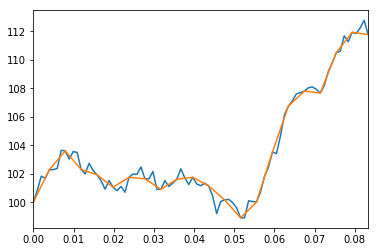

In [21]:
allpaths[0][0].plot()
allpaths[0][1].plot()

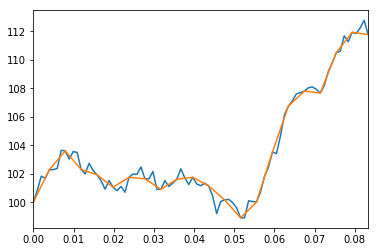

In [22]:
allpaths84[0].plot()
allpaths21[0].plot()

In [ ]:
# calculate portfolio given path
# calculate P&L and cashflow of portfolio

In [89]:
def calcpath(path,phi,K,r,q,vol,T):
    ttm=T-path.index
    bsvpath=np.array([[path.index[j],path.values[j]]+bsv(phi,path.values[j],K,r,q,vol,ttm[j])\
                      for j in range(len(path))])
    return pd.DataFrame(bsvpath,columns=['time','spot','premium','delta'])

In [255]:
def filldf(path,phi,K,r,q,vol,T):
    nstp=len(path)-1
    # calculate t,S(t),premium(t),delta(t)
    df=calcpath(path,phi,K,r,q,vol,T)
    # cashflows for the option
    df['cfwprem']=0
    df.loc[0,'cfwprem']=-df['premium'][0]
    df.loc[nstp,'cfwprem']=df['premium'][nstp]
    df.loc[nstp,'premium']=0
    # calculate time intervals dt
    df['timechg']=df['time'].diff()
    df.loc[0,'timechg']=0
    # calculate changes in delta
    df.loc[nstp,'delta']=0
    df['dltchg']=df['delta'].diff()
    df.loc[0,'dltchg']=0
    # calculate changes in spot price
    df['spotchg']=df['spot'].diff()
    df.loc[0,'spotchg']=0
    # cashflows for the asset
    df['cfwspot']=0
    df.loc[0,'cfwspot']=df['delta'][0]*df['spot'][0]
    df.loc[1:,'cfwspot']=df['dltchg'][1:]*df['spot'][1:]
    # dividend cashflows
    df['cfwdivid']=0
    df.loc[1:,'cfwdivid']=-((df['delta'][0:nstp]*df['spot'][0:nstp]).values)*(np.exp(q*df['timechg'][1:].values)-1)
    # cashflows before interest
    df['cfwprer']=df['cfwprem']+df['cfwspot']+df['cfwdivid']
    # interest and consolidation of cashflows
    df['balance']=0
    df.loc[0,'balance']=df['cfwprer'][0]
    for j in range(1,nstp+1):
        df.loc[j,'balance']=df['balance'][j-1]*(np.exp(r*df['timechg'][j]))+df['cfwprer'][j]
    # portfolio
    df['portf']=df['premium']-df['delta']*df['spot']+df['balance']
    # consolidated discount factor
    return df

In [215]:
#filldf(allpaths[0][0],phi,K,r,q,vol,T)

In [219]:
def portfolio(path,phi,K,r,q,vol,T):
    fulldf=filldf(path,phi,K,r,q,vol,T)
    return pd.Series(fulldf['portf'].values)

In [227]:
#portfolio(allpaths[0][0],phi,K,r,q,vol,T)

In [257]:
def finalpl(path,phi,K,r,q,vol,T):
    portf=portfolio(path,phi,K,r,q,vol,T)
    return portf[len(path)-1]

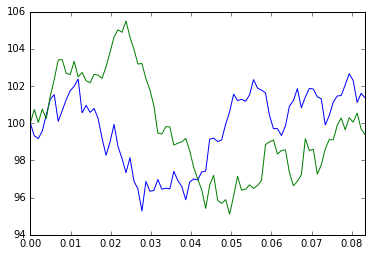

In [240]:
allpaths[0][0].plot()
allpaths[1][0].plot()

In [258]:
finalpl(allpaths[0][0],phi,K,r,q,vol,T)

0.36989658890500721

In [259]:
finalpl(allpaths[1][0],phi,K,r,q,vol,T)

0.41098067330426957

In [246]:
def finalplpaths(paths,phi,K,r,q,vol,T):
    pls=np.array([finalpl(path,phi,K,r,q,vol,T) for path in paths])
    return pd.Series(pls)

This takes forever to run

In [249]:
pl84=finalplpaths(allpaths84,phi,K,r,q,vol,T)

This takes 1/4 of forever to run

In [260]:
pl21=finalplpaths(allpaths21,phi,K,r,q,vol,T)

## Exhibit 1: Histograms for the final profit/loss of the hedging strategy for (a) 21 and (b) 84 rebalancing trades.

(a)

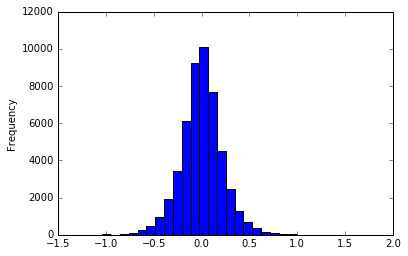

In [251]:
(pl84).plot(kind='hist', bins=30)

(b)

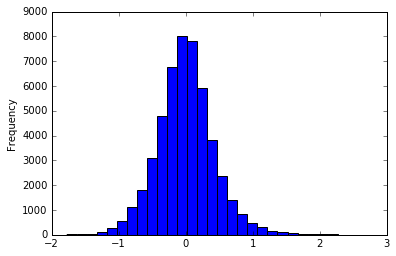

In [261]:
(pl21).plot(kind='hist', bins=30)

## Table 1: Statistical summary of the simulated profit/loss. The fair Black-Scholes value of the option is 2.512

In [268]:
mpl84=pl84.mean()
mpl21=pl21.mean()
stpl84=pl84.std()
stpl21=pl21.std()
stats21=np.array([mpl21,stpl21,100*stpl21/callpr])
stats84=np.array([mpl84,stpl84,100*stpl84/callpr])
dfsumm=pd.DataFrame([stats21,stats84],index=[nst1,nst2],\
                    columns=['Mean P&L', 'Standard Dev. of P&L', 'StDev of P&L as a % of option \
premium'])
dfsumm.index.name='Number of trades'
dfsumm

,Mean P&L,Standard Dev. of P&L,StDev of P&L as a % of option premium
Number of trades,,,
21,0.000671,0.427324,17.010864
84,0.000552,0.216944,8.636087


## Understanding the Results Intuitively

The simulation plots of Exhibit 1 are a compilation of numerical results. We have derived a simple analytical rule that provides good quantitative agreement with these results and lends itself to a simple intuitive interpretation; the standard deviation of the final P&L is given, to a good approximation, by:

(1) $$\sigma _{PL}=\sqrt{\frac{\pi }{4}} \kappa \frac{\sigma}{\sqrt{N}}$$

Here $\kappa$ is the options vega -- the standard Black- Scholes sensitivity of the option price with respect to volatility, evaluated at the initial spot and trading date:

(2) $$\kappa =\frac{dC}{d\sigma }\left(t=0,S=S_0\right)=\frac{S_0 \sqrt{T} \exp \left(-d_1^2\right)}{\sqrt{2 \pi }}$$

where $d_1$ is given the formula:

(3) $$d_1=\frac{\log \left(\frac{S_0}{K}\right)+T \left(r+\frac{\sigma ^2}{2}\right)}{\sigma  \sqrt{T}}$$

as is used in the Black-Scholes formula. The number of times the hedger can rebalance is given by N. If you rebalance four times as frequently, you halve the typical size of the hedging error. The numerical prefactor, $\sqrt{\frac{\pi }{4}}$ is slightly less than one: 0.886; for a rough estimate it can be taken to be one.
Using a standard Black-Scholes calculator, it easy to verify that the initial vega of the option we have analyzed is $\kappa$ = 0.115/vol point. Once you know the relevant vega, it is easy to apply equation 1; for N = 21, we would estimate $\sigma_{PL}$ = 0.443, while $\sigma_{PL}$ = 0.222. These estimates are quite close to the simulation results of Table 1.
There is an even simpler way of using this rule for the case of an option that is struck close to the initial spot price. In this case, since the option price itself is approximately proportional to the volatility, the relation expressing the standard deviation of replication error as a multiple of initial option price becomes:

(4) $$\frac{\sigma _{L P\&}}{C_0}\approx \sqrt{\frac{\pi }{4}}\frac{1}{\sqrt{N}}$$

Observe that the right-hand side of this equation only depends on the number of times you hedge. This simpler approximation remains reasonably accurate: $\sigma_{PL}/C_0$ is 19.3% for N = 21, 9.7% for N = 84.
Equation (1) for the replication error is actually a reasonable approximation of a more complicated formula, which we will not derive here. Although the full formula provides better agreement than Equation (1) for options that are far out-of-the-money, have a longer term to expiration, or are priced under higher interest rates, their qualitative behavior is quite similar. In any case, for a wide range of pricing parameters of practical interest (T < 1 year, r < 10%, strikes close enough to spot, say within 0.25 put-delta), the estimates are quite close.
There is an intuitive way of understanding Equations (1) and (2). When you hedge intermittently rather than continuously along some path to expiration, you are sampling the underlyer price discretely, and therefore obtaining only an approximate measure of the true volatility of the underlyer. Therefore, the estimated volatility itself will have an error. The histograms of Exhibit 2 show the range of volatilities estimated from each of the 50,000 paths used in the simulation analysis.
The volatility measured over all paths is, on average, close to 20%. But there is considerable variation in the volatility measured from discretely sampled prices --- even, as is the case here, when the underlying process really is lognormal with known constant volatility, and no jumps or other deviations are allowed. The discrete sampling itself introduces this error. This error is analogous to the statistical fluctuations that are seen when flipping a fair coin N times -- the measured frequency of heads will on average be 1/2, but there will be variations around the average roughly of size $1/\sqrt{N}$. The same $\sqrt{N}$ shows up here: the standard deviation of the measured volatility based on N samples is $\sigma/\sqrt{2N}$.
Therefore, in an approximate way, the volatility you may actually experience in hedging the option is:

(5) $$\sigma _{\text{sampled}}\approx \sigma \pm \frac{\sigma }{\sqrt{2 N}}$$

Consequently, the option price you may capture by replication is an option price corresponding to a volatility somewhere in this range, so that:

(6) $$c[\sigma _{\text{sampled}}]-c[\sigma]\approx \kappa  \left(\sigma _{\text{sampled}}-\sigma \right)$$

where $C[\sigma]$ is the fair Black-Scholes option price for volatility $\sigma$. We have used the option vega, $\kappa$, to approximately account for the option's sensitivity to this error in volatility. As a result, we should expect an average profit/loss of zero and a standard deviation in profit/loss that is proportional to the standard deviation of measured volatility:

(7) $$\sigma _{PL}\approx \kappa  \frac{\sigma }{\sqrt{2 N}}$$

Equation (7), except for the slightly different numerical coefficient, agrees with the more rigorous result obtained in Equation (1), and provides an easily understandable heuristic explanation for the behavior of the replication error displayed in Exhibit 1.

In [23]:
def rets(x):
    y=x.values
    return pd.Series(y[1:]/y[:-1]-1)

In [24]:
rets(testpath).std()

0.061427075144669385

In [25]:
def logrets(x):
    y=x.values
    return pd.Series(np.log(y[1:]/y[:-1]))

In [26]:
logrets(testpath).std()

0.058529757070119585

In [27]:
rlzvols84=pd.Series([logrets(j[0]).std() for j in allpaths])

In [28]:
rlzvols21=pd.Series([logrets(j[1]).std() for j in allpaths])

## Exhibit 2: Histograms showing the volatilities estimated from (a) 21 and (b) 84 simulated returns.

(a)

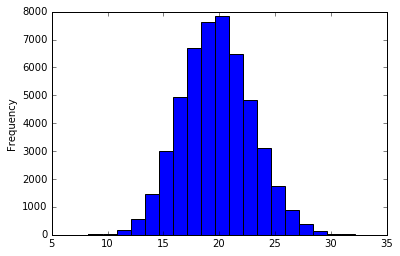

In [29]:
(100*np.sqrt(252)*rlzvols21).plot(kind='hist', bins=20)

(b)

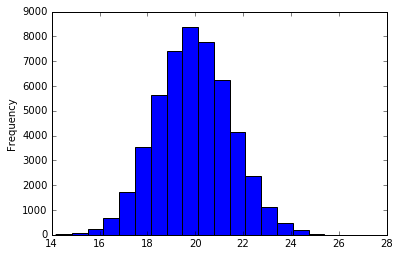

In [30]:
(100*np.sqrt(252*4)*rlzvols84).plot(kind='hist', bins=20)

## Trading Volatility and its Risks

In this note we have focused on only one of the many risks of hedging options. Intermittent hedging alone can lead to large replication errors and consequent P&L fluctuations, even when all other option market parameters are known. The only way to reduce this particular error is to rehedge more frequently, or to run a more closely matched book whose gamma is close to zero, thereby avoiding the need to rehedge. In practice, however, the advantage gained by increased rehedging must be weighed against the losses due to transaction costs and potentially adverse market impact.
Currently, global index volatilities and their skews are extremely high, perhaps making the idea of selling volatility attractive (See the Global Risk and Option Strategy Perspective section in this Quarterly). If implementing this volatility view requires delta-hedging, then our analysis shows that the premium collected by selling options must be at least large enough to leave a cushion for the replication error induced by discrete hedging. This error is not small; expressed in volatility terms, a one-standard-deviation estimate of this error is approximately  \[Sigma] / Sqrt[N], where N is the number of rehedging trades. Including other sources of hedging risk, such as the possibility of jumps, changes in the future levels of volatility, and transaction costs, will only increase the need for an even larger cushion.
Investors interested in trading volatility should be aware that there are other there are other strategies that either allow one to take a volatility position outright, such as volatility swaps, or that contain short volatility exposure link to index exposure -- spreads across options of with different strikes or terms to expirations. Volatility swaps are forward contracts on realized volatility. Much like a standard forward contract, the holder of a long position receives at expiration the difference between the actual volatility of the underlyer over the period and a strike that is set at inception. In this way, the investor can implement a view on volatility while leaving the actual mechanics of capture to the option dealer. More information on volatility trading can be found in the references listed at the end of the note, or from your Goldman Sachs equity derivatives salesperson.

## References

1. Investing in Volatility, E. Derman, Michael Kamal, Iraj Kani, John McClure, Cyrus Pirasteh, Joseph Zou, Quantitative Strategies Research Notes (Goldman Sachs & Co.), October 1996.
2. Valuing Derivatives with Payoff based on Future Realized Volatility, Emanuel Derman, Michael Kamal, Iraj Kani, Joseph Zou, Global Derivatives Quarterly Review, Equity Derivatives Research (Goldman Sachs & Co., July 1996)